# Lab Assignment Three: Extending Logistic Regression

### Authors
- Juliana Antonio
- Xiaona Hang
- Chuanqi Deng


### 1. Preparation and Overview

The "Body Performance Data" sourced from the [Korea Sports Promotion Foundation](https://www.bigdata-culture.kr/bigdata/user/data_market/detail.do?id=ace0aea7-5eee-48b9-b616-637365d665c1), available on Kaggle, comprises 13,393 rows and encompasses 12 features, such as age, gender, height, weight, and more. This dataset, meticulously curated, demonstrates the correlation between age and various exercise performance metrics, thereby providing insights into individual performance grades.

Utilizing this rich dataset, the aim is to classify individuals into distinct performance grades: A (Best), B, C, and D (Worst), based on the aforementioned 12 features. This classification is pivotal for tailoring personalized training plans, catering to diverse needs and abilities. Consequently, gyms and rehabilitation centers stand to benefit significantly from leveraging predictive analytics to craft bespoke training plans, optimizing clients' progress and well-being.

Beyond professional institutions, individuals themselves will be interested in understanding their body performance classification. Armed with this knowledge, they can make informed decisions regarding their fitness journey, setting realistic goals and embracing tailored approaches for holistic improvement.

The deployment of a robust classification model is expected to achieve an accuracy of approximately 80%. By meeting this benchmark, the model ensures reliable predictions, empowering stakeholders to make data-driven decisions with confidence.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm

raw_data = pd.read_csv("data/bodyPerformance.csv")

# preprocessing
data = pd.get_dummies(raw_data, columns=['gender'],dtype=np.int8) # one-hot encoding for gender
labels = data['class'].map(lambda c: ord(c) - ord('A')) # encode lables into integer
data.drop(['class'], axis=1, inplace=True) # remove class column

# scale
scaler = StandardScaler()
features = scaler.fit_transform(data)

# PCA
pca = PCA(8)
pca_feature = pca.fit_transform(features)
raw_data.shape, pca_feature.shape

((13393, 12), (13393, 8))

The dataset has one categorical feature, the gender. One-hot encoding is enployed to convert it into numerical data. Next, the lables/class is moved to another separate variable, lables. Then, the Standard Scaling and PCA are applied to mitigate the difference of multiple features reduce the number of features from 12 to 8.

In [2]:
# breakdown of the variables
pd.DataFrame(pca_feature).describe()

,0,1,2,3,4,5,6,7
count,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04,1.339300e+04
mean,-1.283724e-16,-7.709306e-19,-2.368747e-17,-4.912403e-17,-2.337661e-18,2.952747e-17,-1.345398e-17,5.760945e-17
std,2.386378e+00,1.462662e+00,1.127011e+00,9.438121e-01,8.081770e-01,5.785046e-01,5.602344e-01,4.860709e-01
min,-5.041796e+00,-5.384663e+00,-7.437324e+00,-4.140902e+00,-4.012083e+00,-2.242237e+00,-5.062883e+00,-2.246422e+00
25%,-1.967484e+00,-1.012307e+00,-6.911124e-01,-6.042082e-01,-4.971976e-01,-3.845767e-01,-3.517389e-01,-3.142285e-01
50%,-8.995369e-01,1.073930e-01,5.143689e-02,1.506179e-02,7.247022e-03,1.665698e-02,8.867419e-03,-3.037003e-03
75%,2.360703e+00,1.072822e+00,7.628835e-01,6.133066e-01,5.253231e-01,3.905508e-01,3.792356e-01,3.000243e-01
max,6.506510e+00,7.782459e+00,1.473913e+01,4.345014e+00,1.360873e+01,3.636507e+00,5.873632e+00,6.967697e+00


In [3]:
# test different folds of cross validation
cross_validation_accs = {}
# n fold cross-validation, n: 3-10
for n in tqdm(range(3, 11)):
    # n-fold cross-validation
    cross_validator = KFold(n_splits=n)
    split_indices = cross_validator.split(pca_feature, labels)
    
    # training and testing
    avg_accs = []
    for train_indices, test_indices in split_indices:
        X_train, y_train = pca_feature[train_indices], labels[train_indices]
        X_test, y_test = pca_feature[test_indices], labels[test_indices]
        
        classifier = SVC()
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        avg_accs.append(acc)
    
    cross_validation_accs[n] = avg_accs

100%|██████████| 8/8 [07:52<00:00, 59.07s/it]


Text(0.5, 1.0, 'Cross Validation Accuracies')

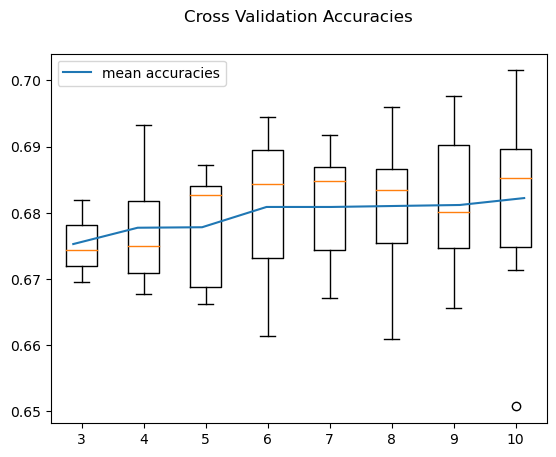

In [4]:
# plot cross validation accuracies
plt.boxplot(cross_validation_accs.values(), labels=list(range(3, 11)))
ax = plt.twiny()
avg_accs = [np.mean(accs) for accs in cross_validation_accs.values()]
ax.plot(avg_accs, label='mean accuracies')
ax.set_axis_off()
ax.legend(loc = 'upper left')
plt.title("Cross Validation Accuracies")

According to the graph above, it is clear that the 7-fold cross-validation has the best accuracies, considering the stablity and median accuracy. Hence, a rougly 86/14 split would be ideal for this dataset.

In [26]:
# use the optimal number of folds for the following analysis
cross_validator = KFold(n_splits=7)
split_indices = cross_validator.split(pca_feature, labels)

**2. Modeling** 

The implementation of logistic regression must be written only from the examples given to you by the instructor. No credit will be assigned to teams that copy implementations from another source, regardless of if the code is properly cited. 

2.1 

Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier:
Ability to choose optimization technique when class is instantiated: either steepest ascent, stochastic gradient ascent, and Newton's method. It is recommended to call this the "solver" input for the class.

Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.  

2.2

Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term(s) "C" to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated.
Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?


**2.1  Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize.**

In [27]:
import numpy as np


class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'

    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta))

    @staticmethod
    def _add_intercept(X):
        return np.hstack((np.ones((X.shape[0], 1)), X))  # add bias term

    # public:
    def predict_proba(self, X, add_intercept=True):
        # add bias term if requested
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_)  # return the probability y=1

    def predict(self, X):
        return (self.predict_proba(X) > 0.5)  # return the actual prediction


blr = BinaryLogisticRegressionBase(0.1)
print(blr)

Base Binary Logistic Regression Object, Not Trainable


In [28]:
# inherit from base class
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    # private:
    def __str__(self):
        if (hasattr(self, 'w_')):
            # is we have trained the object
            return 'Binary Logistic Regression Object with coefficients:\n' + str(self.w_)
        else:
            return 'Untrained Binary Logistic Regression Object'

    def _get_gradient(self, X, y):
        # programming \sum_i (yi-g(xi))xi
        gradient = np.zeros(self.w_.shape)  # set gradient to zero
        for (xi, yi) in zip(X, y):
            # the actual update inside of sum
            gradi = (yi - self.predict_proba(xi, add_intercept=False))*xi
            # reshape to be column vector and add to gradient
            gradient += gradi.reshape(self.w_.shape)

        return gradient/float(len(y))

    # public:
    def fit(self, X, y):
        Xb = self._add_intercept(X)  # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = np.zeros((num_features, 1))  # init weight vector to zeros

        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb, y)
            self.w_ += gradient*self.eta  # multiply by learning rate


blr = BinaryLogisticRegression(0.1)
print(blr)

Untrained Binary Logistic Regression Object


In [29]:
# train the classifier with the optimal number of folds and the pca data
for train_indices, test_indices in split_indices:
    X_train, y_train = pca_feature[train_indices], ((labels[train_indices]) > 1)
    X_test, y_test = pca_feature[test_indices], ((labels[test_indices]) > 1)

# train the classifier with the pca data
# X = pca_feature
# Y = labels > 1
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# train the classifier
blr = BinaryLogisticRegression(eta=0.1, iterations=12)
blr.fit(X_train, y_train)
print(blr)

yhat = blr.predict(X_test)
print('Accuracy of: ', accuracy_score(y_test,yhat))

Binary Logistic Regression Object with coefficients:
[[-0.00029092]
 [ 0.04395626]
 [-0.22565824]
 [-0.248578  ]
 [ 0.10309809]
 [-0.07139034]
 [-0.0323019 ]
 [ 0.00401275]
 [ 0.05577395]]
Accuracy of:  0.7841087297438578


In [30]:
# Train the classifier with more iterations to check if the accuracy improves
params = dict(eta=0.01,
              iterations=500)

blr = BinaryLogisticRegression(**params)
blr.fit(X_train,y_train)
print(blr)
yhat = blr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Binary Logistic Regression Object with coefficients:
[[ 0.01174409]
 [ 0.06053577]
 [-0.49916394]
 [-0.68773908]
 [ 0.32374941]
 [-0.24576778]
 [-0.11727782]
 [ 0.01352371]
 [ 0.20394337]]
Accuracy of:  0.8008363826450601


Use numpy and scipy expit to optimize the Logistic Regression Function

In [14]:
# Vectorized Programming for Logistic Regression
import numpy as np
from scipy.special import expit

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability using expit which is more stable
        return expit(theta)  # 1/(1+np.exp(-theta))

    # overwrite the gradient calculation
    def _get_gradient(self, X, y):
        # get y difference
        ydiff = y-self.predict_proba(X, add_intercept=False).ravel()
        # make ydiff a column vector and multiply through
        gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)

        return gradient.reshape(self.w_.shape)


# use same params as defined above
blr = VectorBinaryLogisticRegression(**params)
blr.fit(X_train, y_train)
print(blr.w_)
yhat = blr.predict(X_test)
print('Accuracy of Vectorized Programing for Regression: ', accuracy_score(y_test,yhat))

C:\Users\seren\AppData\Local\Temp\ipykernel_15296\1043485029.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)


[[ 0.01711285]
 [ 0.06151229]
 [-0.50023012]
 [-0.68692673]
 [ 0.32376052]
 [-0.24934156]
 [-0.12075615]
 [ 0.0245485 ]
 [ 0.2028872 ]]
Accuracy of Vectorized Programing for Regression:  0.799552071668533


One-versus-all to program a Multicalss Logistic Regression

In [31]:
class LogisticRegression:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations

    def __str__(self):
        if (hasattr(self, 'w_')):
            # is we have trained the object
            return 'MultiClass Logistic Regression Object with coefficients:\n' + str(self.w_)
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y)  # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []  # will fill this array with binary classifiers

        for i, yval in enumerate(self.unique_):  # for each unique value
            y_binary = (y == yval)  # create a binary problem
            # train the binary classifier for this class
            blr = VectorBinaryLogisticRegression(self.eta,
                                                 self.iters)
            blr.fit(X, y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)

        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self, X):
        probs = []
        for blr in self.classifiers_:
            # get probability for each classifier
            probs.append(blr.predict_proba(X))

        return np.hstack(probs)  # make into single matrix

    def predict(self, X):
        # take argmax along row
        return self.unique_[np.argmax(self.predict_proba(X), axis=1)]


lr = LogisticRegression(0.1, 1500)
print(lr)

Untrained MultiClass Logistic Regression Object


In [32]:

# train the MultiClass classifier with the optimal number of folds and the pca data
for train_indices, test_indices in split_indices:
    X_train, y_train = pca_feature[train_indices], labels[train_indices]
    X_test, y_test = pca_feature[test_indices], labels[test_indices]


# # train the MultiClass classifier with the pca data without the optimal number of folds
# X = pca_feature
# y = labels
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lr = LogisticRegression(**params)
lr.fit(X_train, y_train)
print(lr)

yhat = lr.predict(X_test)
print('Accuracy of: ', accuracy_score(y_test,yhat))

C:\Users\seren\AppData\Local\Temp\ipykernel_15296\1043485029.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  gradient = np.mean(X * ydiff[:, np.newaxis], axis=0)


MultiClass Logistic Regression Object with coefficients:
[[-0.01174409 -0.06053577  0.49916394  0.68773908 -0.32374941  0.24576778
   0.11727782 -0.01352371 -0.20394337]
 [ 0.01174409  0.06053577 -0.49916394 -0.68773908  0.32374941 -0.24576778
  -0.11727782  0.01352371  0.20394337]]
Accuracy of:  0.8008363826450601


References:
1. https://www.kaggle.com/datasets/kukuroo3/body-performance-data
2. https://www.bigdata-culture.kr/bigdata/user/data_market/detail.do?id=ace0aea7-5eee-48b9-b616-637365d665c1